In [1]:
!pip install -Uqq fastbook
import fastbook

In [2]:
from fastbook import *

In [3]:
!pip install fastai==2.6

In [4]:
import fastai

In [5]:
print(fastai.__version__)

2.6.0


In [6]:
from fastai.vision.all import *

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import tqdm
import warnings
warnings.filterwarnings('ignore')
mpl.rcParams["figure.figsize"] = (18, 12)

In [8]:
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)

In [9]:
torch.cuda.set_device(0)

In [10]:
def seed_everything(seed=0):
    """Initialize the random number generator.

    Parameters:
    seed (int): any number

    Returns:
    int:null

   """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything()

In [11]:
path = Path('./sorghum-id-fgvc-9')
path.ls()

(#4) [Path('sorghum-id-fgvc-9/sample_submission.csv'),Path('sorghum-id-fgvc-9/test'),Path('sorghum-id-fgvc-9/train_cultivar_mapping.csv'),Path('sorghum-id-fgvc-9/train_images')]

# Data exploration

In [12]:
sorghum_df = pd.read_csv(path/'train_cultivar_mapping.csv')
sorghum_df.head()

,image,cultivar
0,2017-06-16__12-24-20-930.png,PI_257599
1,2017-06-02__16-48-57-866.png,PI_154987
2,2017-06-12__13-18-07-707.png,PI_92270
3,2017-06-22__13-18-06-841.png,PI_152651
4,2017-06-26__12-56-48-642.png,PI_176766


In [13]:
allowed_image = []
for i in (path/'train_images').ls():
    va = i.name in sorghum_df.image.to_list()
    if va:
        allowed_image.append(i.name)

In [14]:
sorghum_df = sorghum_df[sorghum_df.image.isin(allowed_image)]

<AxesSubplot:>

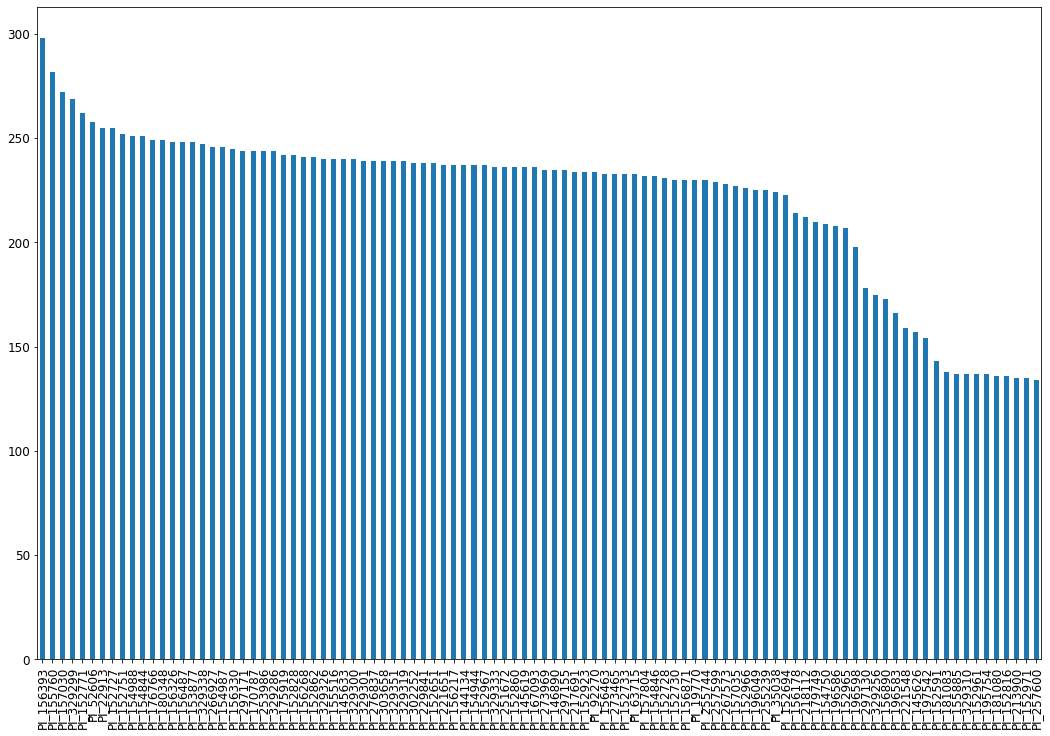

In [15]:
sorghum_df.cultivar.value_counts().plot(kind='bar')

# DataLoaders

In [16]:
dls = ImageDataLoaders.from_df(
    sorghum_df,
    path/'train_images',
    valid_pct=0.10,
    item_tfms=Resize(460),
    batch_tfms=[
        *aug_transforms(size=224, min_scale=0.75),
        Normalize.from_stats(*imagenet_stats)
    ],
    bs=64,
    num_workers=4,
    label_col="cultivar")

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


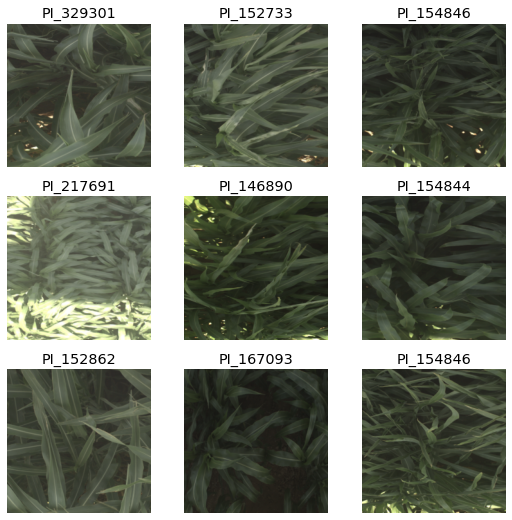

In [17]:
dls.show_batch()

# Create the Learner

In [18]:
learn = cnn_learner(
    dls,
    resnet50,
    metrics=[error_rate, accuracy],
    model_dir="/tmp/model/").to_fp16()

In [19]:
def find_appropriate_lr(model:Learner, lr_diff:int = 15, loss_threshold:float = .05, adjust_value:float = 1, plot:bool = False) -> float:
    """Method that automates the selection of a Learning Rate in Fast.ai

    Parameters:
    model (Learner): The learner
    lr_diff (int): The interval distance by units of the “index of LR” (log transform of LRs) between the right and left bound
    loss_threshold (float): The maximum difference between the left and right bound’s loss values to stop the shift
    adjust_value (float): A coefficient to the final learning rate for pure manual adjustment
    plot (bool): A boolean to show two plots

    Returns:
    float: Best learning rate value to use

   """
    model.lr_find()
    
    losses = np.array(model.recorder.losses)
    assert(lr_diff < len(losses))
    loss_grad = np.gradient(losses)
    lrs = model.recorder.lrs
    
    r_idx = -1
    l_idx = r_idx - lr_diff
    while (l_idx >= -len(losses)) and (abs(loss_grad[r_idx] - loss_grad[l_idx]) > loss_threshold):
        local_min_lr = lrs[l_idx]
        r_idx -= 1
        l_idx -= 1

    lr_to_use = local_min_lr * adjust_value
    
    if plot:
        plt.plot(loss_grad)
        plt.plot(len(losses)+l_idx, loss_grad[l_idx],markersize=10,marker='o',color='red')
        plt.ylabel("Loss")
        plt.xlabel("Index of LRs")
        plt.show()

        plt.plot(np.log10(lrs), losses)
        plt.ylabel("Loss")
        plt.xlabel("Log 10 Transform of Learning Rate")
        loss_coord = np.interp(np.log10(lr_to_use), np.log10(lrs), losses)
        plt.plot(np.log10(lr_to_use), loss_coord, markersize=10,marker='o',color='red')
        plt.show()
        
    return lr_to_use

Wall time: 3min 57s


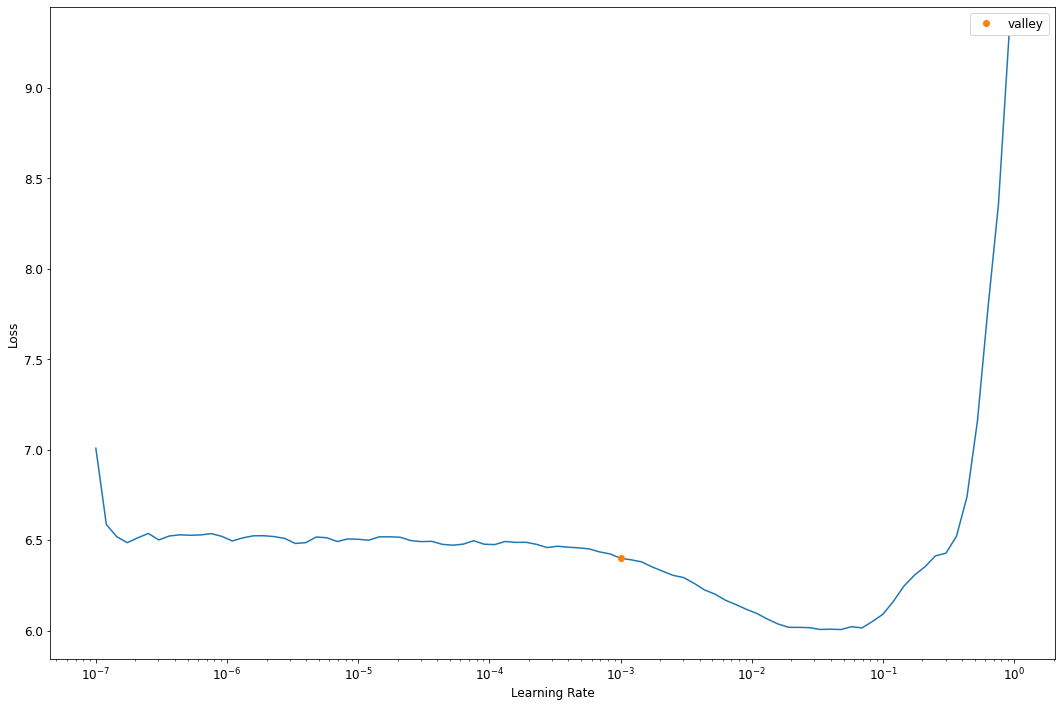

In [20]:
%time lr_to_use = find_appropriate_lr(learn)

In [21]:
lr_to_use

0.005248074602497722

# Training

In [22]:
%time learn.fine_tune(20, lr_to_use)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,3.431170,2.631965,0.677783,0.322217,14:11


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.908235,1.338104,0.380352,0.619649,14:24
1,1.368719,1.016427,0.297431,0.702569,14:45
2,1.154175,0.966149,0.290671,0.709329,13:58
3,1.092307,0.908361,0.275800,0.724200,14:35
4,1.047314,0.903576,0.267237,0.732763,14:41
5,0.886871,0.921769,0.275349,0.724651,14:43
6,0.763194,0.576513,0.191077,0.808923,14:40
7,0.620465,0.595201,0.182064,0.817936,14:38
8,0.507312,0.494880,0.166742,0.833258,17:16
9,0.484220,0.416698,0.129338,0.870662,20:19


Wall time: 5h 16min 36s


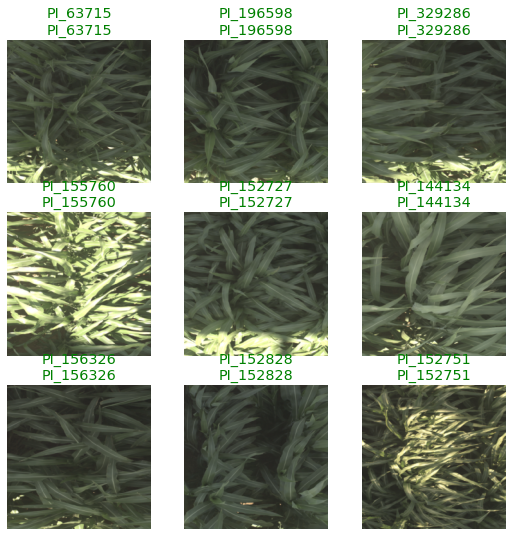

In [23]:
learn.show_results()

In [24]:
interp = ClassificationInterpretation.from_learner(learn)

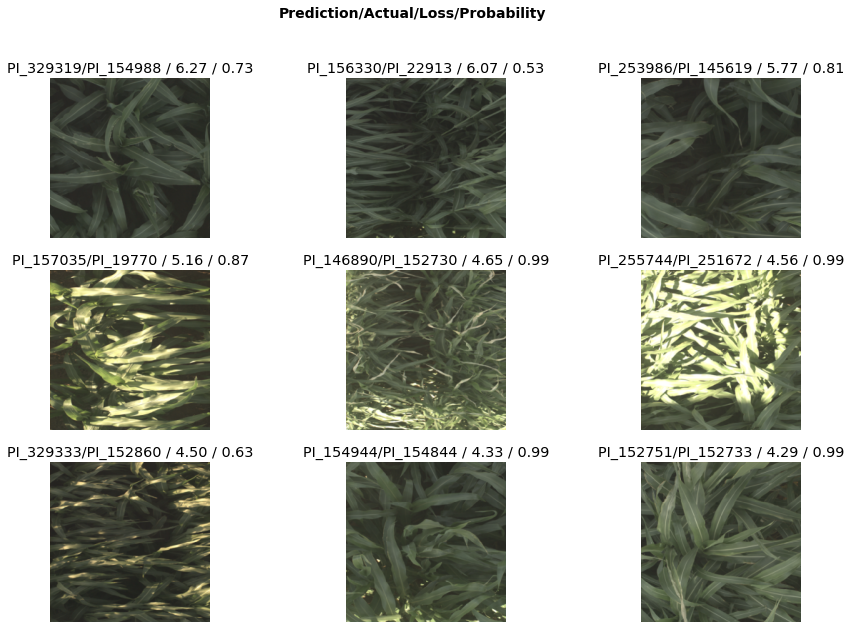

In [25]:
interp.plot_top_losses(9, figsize=(15, 10))

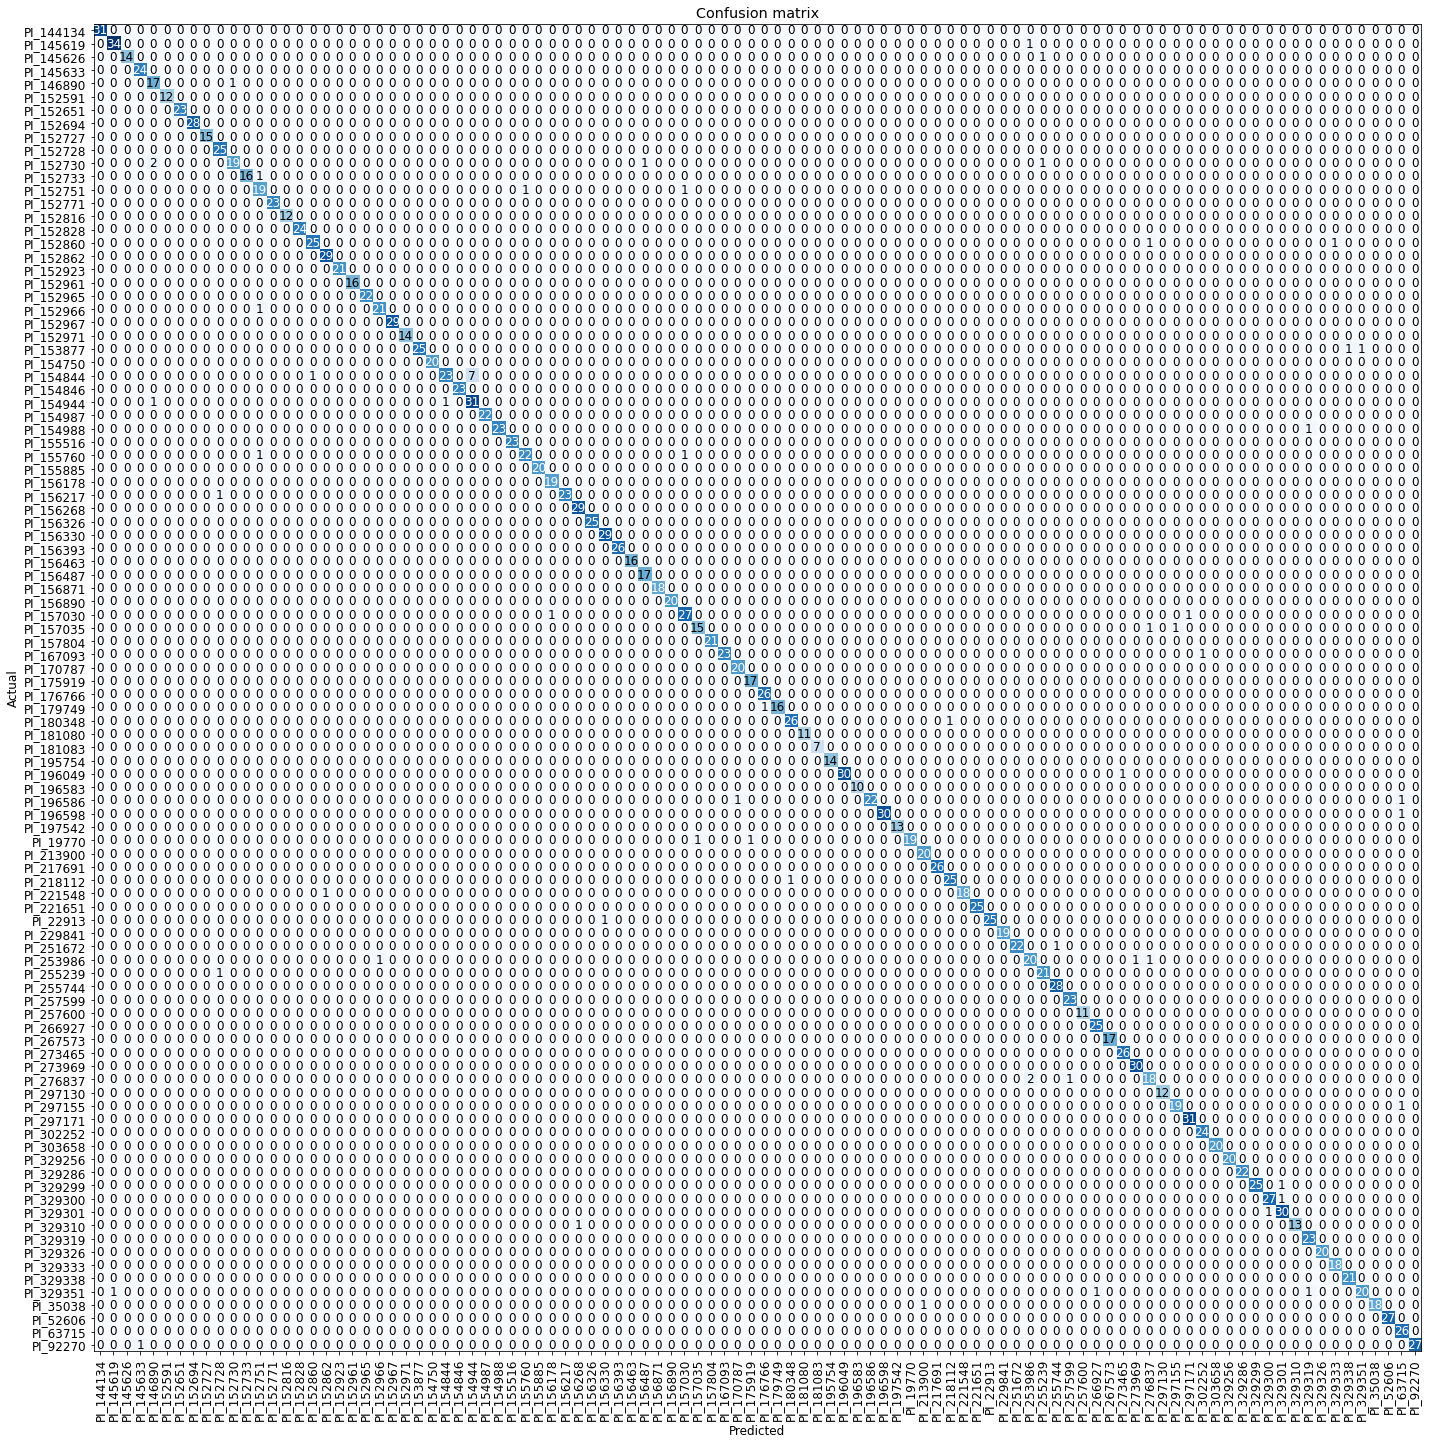

In [26]:
interp.plot_confusion_matrix(figsize=(20, 20))

# Predictions

In [27]:
test_dl = dls.test_dl(get_image_files(path/'test'))

In [28]:
log_preds_test = learn.get_preds(dl=test_dl)
log_preds_test = np.argmax(log_preds_test[0], axis=1)
preds_classes = [dls.vocab[i] for i in log_preds_test]
probs = np.exp(log_preds_test)

In [29]:
submission = pd.DataFrame({ 'filename': os.listdir(path/'test'), 'cultivar': preds_classes })

In [30]:
submission

,filename,cultivar
0,1000005362.png,PI_180348
1,1000099707.png,PI_329333
2,1000135300.png,PI_92270
3,1000136796.png,PI_329256
4,1000292439.png,PI_156393
...,...,...
23634,999578153.png,PI_156217
23635,999692877.png,PI_273465
23636,999756998.png,PI_303658
23637,999892248.png,PI_152965


In [31]:
submission.to_csv('submission.csv', index=False)